## .set files Pre-processing

In [1]:
import numpy as np
import mne
import os
from mne.preprocessing import ICA
from scipy import signal

In [2]:
# Importing all .set files 
# Storing all file paths

def readSetFiles(directory):
    raw = []
    allFilePaths = []
    
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".set"):
                filePath = os.path.join(root, file)
                allFilePaths.append(filePath)
                raw.append(mne.io.read_raw_eeglab(filePath))
    return raw, allFilePaths;

In [3]:
# Path to root directory
rootDirectory = "C:\\Users\\Sai Teja\\Desktop\\New folder\\derivatives"

In [4]:
%%capture
raw, allFilePaths = readSetFiles(rootDirectory)

In [5]:
type(raw[0])

mne.io.eeglab.eeglab.RawEEGLAB

In [5]:
def removeArtifacts(raw_files):
    for i, raw in enumerate(raw_files):
        # Set up ICA parameters
        n_components = 19  # Number of components to estimate
        method = 'fastica'  # ICA method (e.g., FastICA)

        # Create ICA object and fit it to the data
        ica = ICA(n_components=n_components, method=method)
        ica.fit(raw)

        # Plot ICA components
        ica.plot_components()

        # Select components to exclude based on visual inspection
        exclude_components = [0, 3, 5]

        # Remove selected components from the data
        ica.exclude = exclude_components
        cleaned_raw = raw.copy()
        ica.apply(cleaned_raw)

        # Update the list with cleaned data
        raw_files[i] = cleaned_raw
    
    return raw_files

In [6]:
%%capture
raw = removeArtifacts(raw)

In [7]:
# Get the time duration information
raw_time_duration = [r.times[-1] for r in raw] # Duration of the recording in seconds
max_duration = max(raw_time_duration)
max_duration

1281.718

In [8]:
# Max duration file sub-010
raw[9].times[-1]

1281.718

In [9]:
# Every raw file has 19 channels
len(raw[0].ch_names)

19

In [10]:
# Calculate the channel means per raw file
def calculateChannelMeans(raw):
    channel_means = []

    for r in raw:
        channel_names = r.ch_names

        # Calculate the mean for each channel
        file_channel_means = []
        for channel in channel_names:
            data = r.get_data(picks=channel)
            mean = data.mean()
            file_channel_means.append(mean)

        # Store the channel means for the current file
        channel_means.append(file_channel_means)

    return channel_means

In [11]:
allFilesChannelMeans = calculateChannelMeans(raw)

In [12]:
allFilesChannelMeans[0]

[8.581842208000592e-08,
 6.956062851292072e-08,
 -6.268290315022935e-09,
 2.284005646013164e-08,
 6.25317705213722e-09,
 2.0882954573490494e-08,
 6.815508923924862e-09,
 3.0198376482746574e-08,
 1.0520824814074595e-08,
 3.601411088979955e-08,
 3.5246460105099025e-08,
 5.7406687014496726e-08,
 1.858931135044154e-08,
 2.4723996641571562e-08,
 -3.274816263190586e-08,
 9.253959907202836e-09,
 1.7582739016049917e-08,
 9.306834013759002e-09,
 1.060336874282773e-08]

In [13]:
# Channel means per specified interval per file
def channelMeansPerInterval(raw, interval):
    channel_means = []

    for r in raw:
        # Retrieve the channel names
        channel_names = r.ch_names

        # Calculate the number of intervals based on the total duration
        total_duration = r.times[-1]
        num_intervals = int(total_duration / interval)

        # Calculate the mean for each channel in each interval
        file_channel_means = []
        for i in range(num_intervals):
            start_time = i * interval
            end_time = (i + 1) * interval

            # Crop the data to the interval
            interval_raw = r.copy().crop(tmin=start_time, tmax=end_time)
            interval_channel_means = []
            for channel in channel_names:
                data = interval_raw.get_data(picks=channel)
                mean = data.mean()
                interval_channel_means.append(mean)

            file_channel_means.append(interval_channel_means)

        # Store the channel means for the current file
        channel_means.append(file_channel_means)

    return channel_means

In [14]:
# Interval duration
interval = 10

meansPerInterval = channelMeansPerInterval(raw, interval)

In [15]:
# Print the channel means for each data and interval
for i, data_means in enumerate(meansPerInterval):
    print(f"File {i+1}:")
    for j, interval_means in enumerate(data_means):
        interval_start = j * interval
        interval_end = (j + 1) * interval
        print(f"Interval {j+1}: {interval_start}-{interval_end} seconds")
        channel_names = interval_means
        for k, channel_mean in enumerate(channel_names):
            print(f"Channel {k+1}: {channel_mean}")

File 1:
Interval 1: 0-10 seconds
Channel 1: 3.1448485739395887e-07
Channel 2: 2.496304005203522e-07
Channel 3: 6.347133895275654e-08
Channel 4: 3.833617518810454e-07
Channel 5: 1.1096947930183501e-07
Channel 6: 4.7348070556969593e-07
Channel 7: 7.088690114539681e-08
Channel 8: 3.031173553766822e-07
Channel 9: 3.713300394526012e-07
Channel 10: 2.0147340611338503e-07
Channel 11: 3.7530690256719023e-07
Channel 12: 3.175243458106137e-07
Channel 13: 7.280542613721326e-08
Channel 14: 2.3460344293109844e-07
Channel 15: 3.7254885555299357e-07
Channel 16: 4.301538152513994e-07
Channel 17: 1.2143635617207148e-07
Channel 18: 2.1419750555782517e-07
Channel 19: 3.517705468085539e-07
Interval 2: 10-20 seconds
Channel 1: 7.020872040281293e-07
Channel 2: 5.627449087796713e-07
Channel 3: 3.9767406728086074e-07
Channel 4: 4.1750798538240767e-07
Channel 5: 5.636130321958475e-07
Channel 6: 5.026241430224705e-07
Channel 7: 5.492160080266148e-07
Channel 8: 8.196761599093298e-07
Channel 9: -3.004689677312831

Channel 2: -3.6634879278482283e-07
Channel 3: -4.1904978474194056e-07
Channel 4: -9.063366182489402e-08
Channel 5: -2.442248792580813e-07
Channel 6: 1.1473811644553287e-07
Channel 7: -1.0863612232812864e-07
Channel 8: -1.479192065659152e-07
Channel 9: -1.148302718415952e-07
Channel 10: 1.4169340512256976e-08
Channel 11: -3.918157974318746e-07
Channel 12: -3.2649465182299674e-07
Channel 13: -3.598210318487279e-07
Channel 14: -3.614700222112781e-07
Channel 15: -1.2749471178576952e-07
Channel 16: 1.5609440579795528e-07
Channel 17: -2.9248704922557666e-07
Channel 18: -2.8666382624030654e-07
Channel 19: -1.255771523287024e-07
Interval 3: 20-30 seconds
Channel 1: 1.8908327989754685e-07
Channel 2: 1.4396763069152136e-08
Channel 3: 1.902432090492514e-07
Channel 4: -7.202870944357047e-08
Channel 5: 3.9089134454822676e-07
Channel 6: -3.426611580372346e-07
Channel 7: 2.5817907798641925e-07
Channel 8: -3.3481504618222596e-07
Channel 9: -2.2343794587966275e-08
Channel 10: 3.9025700107724994e-08
Cha

Interval 2: 10-20 seconds
Channel 1: 6.434571867667206e-08
Channel 2: -5.971208861008389e-09
Channel 3: -1.7640202479591004e-07
Channel 4: -1.6259920125402677e-07
Channel 5: -2.2823435438212316e-07
Channel 6: 4.7142719739664375e-07
Channel 7: 1.038302603143248e-07
Channel 8: 2.2044462806437026e-07
Channel 9: 6.133563292523584e-08
Channel 10: 8.206507947872139e-08
Channel 11: 1.1717687720933056e-07
Channel 12: -4.3525352020330886e-07
Channel 13: -1.9432685156361288e-08
Channel 14: 1.958542106620527e-07
Channel 15: -1.7927894453776304e-07
Channel 16: 4.1818243045231965e-09
Channel 17: 3.402495770693e-08
Channel 18: -2.108534225336285e-07
Channel 19: 1.3082240972529423e-07
Interval 3: 20-30 seconds
Channel 1: -3.315832824987356e-06
Channel 2: -2.889162541226852e-06
Channel 3: -3.2060255228977384e-06
Channel 4: -2.855390097586992e-06
Channel 5: -2.968422165282633e-06
Channel 6: -3.3177213838623394e-06
Channel 7: -3.107941067895335e-06
Channel 8: -3.048104448179777e-06
Channel 9: -3.0105446

Channel 10: -6.355401501900902e-07
Channel 11: -7.487868622743219e-07
Channel 12: -8.330240694842003e-07
Channel 13: -6.212698777894676e-07
Channel 14: -5.089370950977228e-07
Channel 15: -6.927949313805746e-07
Channel 16: -5.844415038152552e-07
Channel 17: -9.865520130567583e-07
Channel 18: -1.0121298915349186e-06
Channel 19: -6.94474712591582e-07
Interval 5: 40-50 seconds
Channel 1: 5.32095151937673e-07
Channel 2: 4.1668169847176147e-07
Channel 3: 5.695018843890631e-07
Channel 4: 5.655612728008434e-07
Channel 5: 3.7387002764733e-07
Channel 6: 5.903451930842966e-07
Channel 7: 9.563433054478983e-08
Channel 8: 3.933043227119241e-07
Channel 9: 5.062244582939664e-07
Channel 10: 3.5620789150965603e-07
Channel 11: 5.065335653859285e-07
Channel 12: 5.77502040893914e-07
Channel 13: 3.932293166505772e-07
Channel 14: -1.057377765425783e-08
Channel 15: 4.5571838196404114e-07
Channel 16: 5.012170965284526e-07
Channel 17: 6.238021323142669e-07
Channel 18: 5.029646289302759e-07
Channel 19: 3.3753615

Channel 15: -7.860037688717659e-07
Channel 16: -7.03089638635354e-07
Channel 17: -5.677928727504286e-07
Channel 18: -4.172232792644036e-07
Channel 19: -5.505447260024171e-07
Interval 123: 1220-1230 seconds
Channel 1: -7.533651451593047e-07
Channel 2: -6.048360206697853e-07
Channel 3: -3.7007378474055883e-07
Channel 4: -4.929089109233018e-07
Channel 5: -6.145719314158364e-07
Channel 6: -6.188654675808878e-07
Channel 7: -6.52762342069815e-07
Channel 8: -7.29725697074681e-07
Channel 9: -6.436208592422608e-07
Channel 10: -7.454418886614197e-07
Channel 11: -5.741024678488399e-07
Channel 12: -6.907099341235233e-07
Channel 13: -5.195201258224636e-07
Channel 14: -5.342459433507012e-07
Channel 15: -5.050823329512699e-07
Channel 16: -6.370899498192336e-07
Channel 17: -5.552079363022641e-07
Channel 18: -4.4125588382018477e-07
Channel 19: -5.526061969977143e-07
Interval 124: 1230-1240 seconds
Channel 1: 1.070802481295934e-06
Channel 2: 8.871262318415185e-07
Channel 3: 7.70412402228699e-07
Channel 

Channel 2: 7.7208959790434e-07
Channel 3: 5.138912507577222e-07
Channel 4: 1.5163146636395206e-06
Channel 5: 4.190082977827119e-07
Channel 6: -4.047790940068033e-07
Channel 7: 4.1138226034037237e-07
Channel 8: 3.9085414893630524e-07
Channel 9: 1.0624222612842954e-09
Channel 10: 2.509606019098e-07
Channel 11: 4.333003123779925e-07
Channel 12: 4.769217037907804e-07
Channel 13: 4.920576321976616e-07
Channel 14: 3.2996083273082783e-07
Channel 15: 3.526863410268685e-07
Channel 16: 1.0177935156212787e-07
Channel 17: 6.445964836994906e-07
Channel 18: 7.561264463746865e-07
Channel 19: -2.4214519603380735e-08
Interval 27: 260-270 seconds
Channel 1: -8.088027201832105e-07
Channel 2: -5.886546910134863e-07
Channel 3: -4.4287386881927816e-07
Channel 4: -8.357200015244767e-07
Channel 5: -3.1049209192072623e-07
Channel 6: 2.9919244600346034e-07
Channel 7: -3.7198511657729584e-07
Channel 8: -2.0477794014393944e-07
Channel 9: -6.835027332348635e-08
Channel 10: -1.3374921858169274e-07
Channel 11: -2.99

Channel 19: 4.394858209553263e-08
Interval 62: 610-620 seconds
Channel 1: 6.25713237203319e-07
Channel 2: 4.2041394971967505e-07
Channel 3: 4.952809989251909e-07
Channel 4: 5.164210477437703e-07
Channel 5: 2.737445032894131e-07
Channel 6: 1.7753768251336297e-07
Channel 7: -5.452799050857255e-08
Channel 8: 8.112445852031895e-07
Channel 9: 5.667489312940137e-07
Channel 10: 3.9412341468418094e-07
Channel 11: 1.0869518992551054e-07
Channel 12: 7.788029455747666e-07
Channel 13: 3.54252283107391e-07
Channel 14: 1.020187925023149e-06
Channel 15: 5.303932614423951e-08
Channel 16: 7.328426638435134e-07
Channel 17: 5.132761381049076e-07
Channel 18: 7.740159842575299e-07
Channel 19: 3.7403758293221735e-07
Interval 63: 620-630 seconds
Channel 1: -2.9200104482106016e-07
Channel 2: -3.301482802486831e-07
Channel 3: -3.4218815291182063e-07
Channel 4: -2.830905515972481e-07
Channel 5: -2.574123205044419e-07
Channel 6: -1.1711512712974318e-07
Channel 7: 1.281156563867125e-07
Channel 8: -8.3043652773043

Channel 6: 4.494351653676095e-07
Channel 7: 2.973010254077403e-07
Channel 8: 6.034621408258382e-07
Channel 9: 6.505410679772229e-07
Channel 10: 3.349977341450196e-07
Channel 11: 4.562390951286882e-07
Channel 12: 2.951642867265427e-07
Channel 13: 3.125505185613606e-07
Channel 14: 5.149666246315905e-07
Channel 15: 3.259977854026784e-07
Channel 16: 4.201727500159815e-07
Channel 17: 7.348533654710351e-07
Channel 18: 3.284512318485504e-07
Channel 19: 3.59622368150906e-07
Interval 68: 670-680 seconds
Channel 1: -1.568674056107433e-07
Channel 2: -3.0017829599070063e-07
Channel 3: -1.850362023231423e-07
Channel 4: 5.096385295216535e-07
Channel 5: -1.1301047725097134e-06
Channel 6: -1.0803774266925125e-06
Channel 7: -1.2553301841944956e-06
Channel 8: -1.3216335117052933e-06
Channel 9: -1.21676171877463e-06
Channel 10: -1.2729540428908018e-06
Channel 11: -7.876563426490568e-07
Channel 12: -1.025636034827784e-06
Channel 13: -4.907252310874914e-07
Channel 14: -1.3016243967682434e-06
Channel 15: -1

Channel 1: 1.4010789415152927e-06
Channel 2: 1.6431772153762063e-06
Channel 3: 1.5555871791031432e-06
Channel 4: 1.6798280463147647e-06
Channel 5: 1.8396806211357021e-06
Channel 6: 1.5888798773654425e-06
Channel 7: 1.847576508388529e-06
Channel 8: 1.5178190270721363e-06
Channel 9: 1.7226523027039985e-06
Channel 10: 1.743527895737294e-06
Channel 11: 1.3564404662798242e-06
Channel 12: 1.4085758785754142e-06
Channel 13: 1.449350957651518e-06
Channel 14: 1.307533318800448e-06
Channel 15: 1.6735923354274986e-06
Channel 16: 1.8631773685554326e-06
Channel 17: 1.7094729470786387e-06
Channel 18: 1.7629134657613678e-06
Channel 19: 1.8159418949249996e-06
Interval 35: 340-350 seconds
Channel 1: 8.433518636161385e-07
Channel 2: 5.741972531810432e-07
Channel 3: 6.188478781758982e-07
Channel 4: 5.452845462721165e-07
Channel 5: 5.611760421871752e-07
Channel 6: 8.466777885582483e-07
Channel 7: 3.9533310848708527e-07
Channel 8: 5.590585205659707e-07
Channel 9: 6.754973857560366e-07
Channel 10: 1.1257980

Channel 1: -6.708683058868499e-07
Channel 2: -6.677271508992537e-07
Channel 3: -7.461442466540716e-07
Channel 4: -5.50523337011956e-07
Channel 5: -7.919693946041944e-07
Channel 6: -6.062780777904643e-07
Channel 7: -7.841207843531029e-07
Channel 8: -4.5921469998289734e-07
Channel 9: -6.841318779192289e-07
Channel 10: -7.129830187330659e-07
Channel 11: -1.1056553978104555e-06
Channel 12: -6.646101911893353e-07
Channel 13: -8.866590641488788e-07
Channel 14: -4.860601389501713e-07
Channel 15: -7.547011008731075e-07
Channel 16: -6.827724847995592e-07
Channel 17: -7.258372611687164e-07
Channel 18: -4.456237422134458e-07
Channel 19: -6.689332891112364e-07
Interval 60: 590-600 seconds
Channel 1: 8.905199094079412e-07
Channel 2: 9.516834172847757e-07
Channel 3: 9.047527271809924e-07
Channel 4: 7.394528197647344e-07
Channel 5: 8.185214108493895e-07
Channel 6: 7.506751001192527e-07
Channel 7: 7.736533638970713e-07
Channel 8: 8.036309976713289e-07
Channel 9: 1.3246614967481652e-06
Channel 10: 8.30

Channel 19: -1.3793186464275203e-06
Interval 73: 720-730 seconds
Channel 1: 1.3472601598338036e-06
Channel 2: 1.2515792214107114e-06
Channel 3: 1.3449708682199472e-06
Channel 4: 1.1863009583857022e-06
Channel 5: 1.1672084576764717e-06
Channel 6: 1.2590927020711812e-06
Channel 7: 1.1744999859822412e-06
Channel 8: 6.108057085800559e-07
Channel 9: 1.5447950586197773e-06
Channel 10: 1.4725884859041951e-06
Channel 11: 1.2964321765232603e-06
Channel 12: 1.2423288942558003e-06
Channel 13: 1.2122751678676714e-06
Channel 14: 1.1960224973857005e-06
Channel 15: 1.10705283834994e-06
Channel 16: 1.1983786519011221e-06
Channel 17: 1.1345691771037768e-06
Channel 18: 1.3066736746329654e-06
Channel 19: 9.29019928384443e-07
Interval 74: 730-740 seconds
Channel 1: 4.6648646175672205e-07
Channel 2: 6.471752450070481e-07
Channel 3: 4.1863588921527434e-07
Channel 4: 1.0516432800760025e-06
Channel 5: 4.223713002371867e-07
Channel 6: 5.037804734259407e-07
Channel 7: 1.145034446728823e-06
Channel 8: 7.90376416

Channel 15: 8.355414193537905e-07
Channel 16: 8.129659210008532e-07
Channel 17: 9.549333471422972e-07
Channel 18: 1.0237073306130733e-06
Channel 19: 7.590306948141787e-07
Interval 72: 710-720 seconds
Channel 1: -8.3537650356217e-07
Channel 2: -4.7277494181601497e-07
Channel 3: -1.0605251691171239e-06
Channel 4: -5.648335408786978e-07
Channel 5: -2.1480877675576995e-07
Channel 6: -2.676509698680262e-07
Channel 7: 5.065112624853517e-07
Channel 8: 6.59671750797969e-07
Channel 9: 8.030268629227242e-07
Channel 10: 7.743852118549767e-07
Channel 11: -7.82417228615243e-07
Channel 12: 3.817064281363214e-08
Channel 13: 2.8734981097574573e-07
Channel 14: 2.2491572733531593e-06
Channel 15: 4.908756618383077e-07
Channel 16: 9.460797796766201e-07
Channel 17: -4.902066566941293e-08
Channel 18: 3.512031048674381e-07
Channel 19: 2.6220627027449557e-07
Interval 73: 720-730 seconds
Channel 1: 4.3837960312279145e-06
Channel 2: 3.8775617445262904e-06
Channel 3: 3.4417258196756576e-06
Channel 4: 1.386835620

Channel 12: 1.6439628059044494e-06
Channel 13: 1.3966395208841507e-06
Channel 14: 1.3842335412728723e-06
Channel 15: 1.8167316410461656e-06
Channel 16: 1.4001183385699623e-06
Channel 17: 1.409158281132015e-06
Channel 18: 1.4337205776779933e-06
Channel 19: 1.3945012700490702e-06
Interval 45: 440-450 seconds
Channel 1: -8.323223324840194e-07
Channel 2: -8.253721886594948e-07
Channel 3: -4.458498376425124e-07
Channel 4: -4.913921250270155e-07
Channel 5: -1.8468209644399883e-07
Channel 6: -4.463793220886265e-07
Channel 7: -5.4357327115533385e-08
Channel 8: -4.014302591364707e-07
Channel 9: -2.6991051250608685e-07
Channel 10: 4.033580788468746e-07
Channel 11: -7.442778706513883e-07
Channel 12: -2.99472515964158e-07
Channel 13: -2.425910553283134e-07
Channel 14: -3.333484901223041e-07
Channel 15: -7.026694811137826e-07
Channel 16: -3.8102055231636574e-07
Channel 17: -6.225382337079305e-07
Channel 18: -5.99466543445717e-07
Channel 19: -3.7100023044748397e-07
Interval 46: 450-460 seconds
Chann

Channel 11: -9.607421500336691e-07
Channel 12: -6.267830869862406e-07
Channel 13: -9.208537150930248e-07
Channel 14: -8.972636936507844e-07
Channel 15: -8.707973498727171e-07
Channel 16: -1.153981637763969e-06
Channel 17: -8.641922280457766e-07
Channel 18: -5.859992735716103e-07
Channel 19: -7.887859390882677e-07
Interval 17: 160-170 seconds
Channel 1: 1.3647525314567596e-07
Channel 2: 7.709752053531473e-07
Channel 3: 6.240111093853324e-07
Channel 4: 8.12273997743076e-07
Channel 5: 5.133698749070868e-07
Channel 6: 7.643697936801073e-07
Channel 7: 4.2039198471262525e-07
Channel 8: 6.757114904393431e-09
Channel 9: 8.414370782733561e-07
Channel 10: 7.758002788270387e-07
Channel 11: 8.429624761912589e-07
Channel 12: 8.836800781759548e-07
Channel 13: 7.979241613672587e-07
Channel 14: 6.09831384682749e-07
Channel 15: 6.224603639111674e-07
Channel 16: 8.9242852631251e-07
Channel 17: 6.971509908252212e-07
Channel 18: 2.718613187578206e-07
Channel 19: 6.306920928365082e-07
Interval 18: 170-180 

Channel 6: -4.690217620641215e-07
Channel 7: -6.457569682691155e-08
Channel 8: -6.684069246347021e-08
Channel 9: -6.944801294730977e-08
Channel 10: -2.0661633804764374e-08
Channel 11: 2.5361866056481753e-07
Channel 12: -9.428452014749271e-08
Channel 13: 1.5667070906131274e-07
Channel 14: -1.9194356033819618e-07
Channel 15: -2.0068176955425956e-07
Channel 16: -3.744775580580843e-07
Channel 17: -3.937324342336864e-08
Channel 18: 8.22467324611435e-09
Channel 19: -1.4353540799704255e-07
Interval 53: 520-530 seconds
Channel 1: -6.130755124897458e-07
Channel 2: -5.54113570073011e-07
Channel 3: -7.385686089642517e-07
Channel 4: -4.768586527464463e-07
Channel 5: -9.011220536897515e-07
Channel 6: -8.571242594362981e-07
Channel 7: -8.417222161782056e-07
Channel 8: -8.025738831034365e-07
Channel 9: -9.207435334603496e-07
Channel 10: -9.881398219368786e-07
Channel 11: -6.349049884738053e-07
Channel 12: -6.673881637122774e-07
Channel 13: -7.296958272728396e-07
Channel 14: -6.094474368064356e-07
Cha

Channel 3: -4.949041959516355e-08
Channel 4: -3.262338430194657e-07
Channel 5: -1.1402412188684856e-07
Channel 6: -6.330162708701929e-07
Channel 7: -3.641357356525804e-08
Channel 8: -1.139541520131111e-07
Channel 9: 1.9113998603932465e-07
Channel 10: 1.0020498052864827e-07
Channel 11: 1.0900002282401308e-07
Channel 12: -1.305272938662242e-07
Channel 13: 1.4655344461356126e-07
Channel 14: -2.565816392184782e-07
Channel 15: 1.2778999198062084e-07
Channel 16: -9.693331523393699e-08
Channel 17: -2.4198780792263736e-07
Channel 18: -3.0624071204225584e-07
Channel 19: -1.5037289914073116e-07
Interval 83: 820-830 seconds
Channel 1: 7.793170836311522e-07
Channel 2: 6.370791300505286e-07
Channel 3: 9.87224877895355e-07
Channel 4: 6.001110719278661e-07
Channel 5: 8.989214920001207e-07
Channel 6: 5.935067328010949e-07
Channel 7: 4.848020655482009e-07
Channel 8: 4.942831272155362e-07
Channel 9: 4.3386100252571484e-07
Channel 10: 4.2682563312117246e-07
Channel 11: 7.852282387070026e-07
Channel 12: 5

Interval 57: 560-570 seconds
Channel 1: 1.3302190686257735e-06
Channel 2: 1.7584225789491264e-06
Channel 3: 1.104958271913618e-06
Channel 4: 2.417336953680355e-06
Channel 5: 1.3313621019213653e-06
Channel 6: 1.5084527688089957e-06
Channel 7: 1.4533166594032359e-06
Channel 8: 1.8007137634917615e-06
Channel 9: 1.3103003894757977e-06
Channel 10: 5.631531901044754e-07
Channel 11: 1.1308106215046308e-06
Channel 12: 1.6102835456851374e-06
Channel 13: 1.0832227332846537e-06
Channel 14: 1.3613673920683023e-06
Channel 15: 1.257633141256176e-06
Channel 16: 1.2208453661058303e-06
Channel 17: 2.493278288235854e-06
Channel 18: 1.7559895115907049e-06
Channel 19: 1.4555097422984868e-06
Interval 58: 570-580 seconds
Channel 1: -6.677306934604389e-07
Channel 2: -1.1886336998258225e-06
Channel 3: -5.451274767510882e-07
Channel 4: -1.4040521688395623e-06
Channel 5: -3.846255344052712e-07
Channel 6: -6.978241301870379e-07
Channel 7: -5.939308758312157e-07
Channel 8: -1.0754837799155391e-06
Channel 9: -9.78

Channel 6: 1.6088107690356914e-06
Channel 7: 1.327109208311405e-06
Channel 8: 1.525354066071567e-06
Channel 9: 1.5950087641991934e-06
Channel 10: 1.3709384226858755e-06
Channel 11: 1.793607132563487e-06
Channel 12: 1.9006208459310188e-06
Channel 13: 1.6234100100662154e-06
Channel 14: 1.4810674904167746e-06
Channel 15: 2.04112718646509e-06
Channel 16: 1.507953214690922e-06
Channel 17: 1.8003816408696155e-06
Channel 18: 1.5634326907360927e-06
Channel 19: 1.492001691585557e-06
Interval 19: 180-190 seconds
Channel 1: -2.5381144749915813e-06
Channel 2: -2.653321285811728e-06
Channel 3: -2.9744614461718606e-06
Channel 4: -2.870000032873183e-06
Channel 5: -2.128404803916642e-06
Channel 6: -2.548573076193737e-06
Channel 7: -2.4469129470833954e-06
Channel 8: -2.6359335850857775e-06
Channel 9: -2.4833522222277883e-06
Channel 10: -1.8179666533824884e-06
Channel 11: -2.4578914645676664e-06
Channel 12: -2.106268022963084e-06
Channel 13: -2.3885366683650213e-06
Channel 14: -2.3484690043187942e-06
Ch

Channel 13: -9.514750975337704e-07
Channel 14: -1.058344271250734e-06
Channel 15: -1.10730478542702e-06
Channel 16: -8.527321120916679e-07
Channel 17: -8.603376871336965e-07
Channel 18: -9.353334973603196e-07
Channel 19: -8.08395053636691e-07
Interval 60: 590-600 seconds
Channel 1: 2.6674642633149065e-06
Channel 2: 2.617929494428696e-06
Channel 3: 2.6791986847373206e-06
Channel 4: 2.4899538185631993e-06
Channel 5: 2.6288484147731397e-06
Channel 6: 1.588690496731773e-06
Channel 7: 2.754356621468611e-06
Channel 8: 2.813177072386545e-06
Channel 9: 2.9838011248504393e-06
Channel 10: 3.0711313451097524e-06
Channel 11: 2.673272396334103e-06
Channel 12: 2.6099007060780744e-06
Channel 13: 2.818144233831984e-06
Channel 14: 2.784245616356648e-06
Channel 15: 3.0336118523350916e-06
Channel 16: 2.5715837582200403e-06
Channel 17: 2.7033954255303265e-06
Channel 18: 2.6011800937187713e-06
Channel 19: 2.816323655160603e-06
Interval 61: 600-610 seconds
Channel 1: -2.1835887055588094e-06
Channel 2: -1.90

Channel 10: -1.3055986329054578e-06
Channel 11: -1.8670043748055267e-06
Channel 12: -1.6156197940885698e-06
Channel 13: -1.4646160719943566e-06
Channel 14: -1.6081841213290511e-06
Channel 15: -1.623271673272229e-06
Channel 16: -1.288701901470266e-06
Channel 17: -1.3391936719857202e-06
Channel 18: -1.2562078144644615e-06
Channel 19: -1.037532680362687e-06
Interval 37: 360-370 seconds
Channel 1: -5.279227077951481e-07
Channel 2: -5.054068063606045e-07
Channel 3: -6.992615547690248e-07
Channel 4: -5.715636853167988e-07
Channel 5: -8.259202656946255e-07
Channel 6: -7.727841886743643e-07
Channel 7: -8.941657633679864e-07
Channel 8: -6.76081872958483e-07
Channel 9: -1.603985634052483e-06
Channel 10: -6.579560346915113e-07
Channel 11: -4.993122393876761e-07
Channel 12: -5.239110351309527e-07
Channel 13: -6.334212262161036e-07
Channel 14: -4.433846611047943e-07
Channel 15: -5.464657010626777e-07
Channel 16: -8.198542260185814e-07
Channel 17: -7.115108080566675e-07
Channel 18: -7.92507171836544

Channel 7: 1.0264857731472465e-06
Channel 8: 1.3830726439054307e-06
Channel 9: 1.2590539764973827e-06
Channel 10: 1.7996676352968293e-06
Channel 11: -2.2729181180494337e-07
Channel 12: -5.161777499897135e-07
Channel 13: 6.961776492257871e-07
Channel 14: 5.649584284656665e-07
Channel 15: 1.0530903097908654e-06
Channel 16: 1.1251243267748486e-06
Channel 17: 5.5546005428150166e-08
Channel 18: 5.651179376011914e-07
Channel 19: 9.926517346797838e-07
Interval 21: 200-210 seconds
Channel 1: -2.562278267735199e-07
Channel 2: -1.482257756417722e-07
Channel 3: -4.488739110017572e-07
Channel 4: -1.724611229971664e-07
Channel 5: -6.085623707815735e-07
Channel 6: -4.3131388425254867e-07
Channel 7: -6.842064679449663e-07
Channel 8: -1.1500186982113892e-06
Channel 9: -6.193501401645947e-07
Channel 10: -1.3397086310958286e-06
Channel 11: -3.401627848329413e-07
Channel 12: -1.2413696526845902e-07
Channel 13: -5.305643247659972e-07
Channel 14: -4.948204410050911e-07
Channel 15: -5.321675690958087e-07
Ch

Channel 17: 6.908227201931094e-07
Channel 18: 8.766845029326833e-07
Channel 19: 1.0564216903524812e-06
Interval 6: 50-60 seconds
Channel 1: -5.236039073996014e-07
Channel 2: -1.3071130141177528e-06
Channel 3: -9.197696198659124e-07
Channel 4: -9.011445084941923e-07
Channel 5: -7.425344253881472e-07
Channel 6: -5.684050574064034e-07
Channel 7: -1.0572740945242089e-06
Channel 8: -8.486591828328978e-07
Channel 9: -1.0609135346069479e-06
Channel 10: -8.312073564602065e-07
Channel 11: -4.535413652686294e-07
Channel 12: -2.2360656047377634e-06
Channel 13: -1.08666779019803e-06
Channel 14: -1.1529647131467125e-06
Channel 15: -1.270947114895797e-06
Channel 16: -1.1148724838623737e-06
Channel 17: -7.381009477361103e-07
Channel 18: -6.880861165878867e-07
Channel 19: -9.495324424657518e-07
Interval 7: 60-70 seconds
Channel 1: 2.61316618419693e-07
Channel 2: 6.680942622835793e-08
Channel 3: 4.07672200511193e-07
Channel 4: 3.27270500963847e-08
Channel 5: -1.7361253171926412e-07
Channel 6: -4.152174

Channel 8: 1.3424470170725611e-06
Channel 9: 1.4398260035950486e-06
Channel 10: 1.470858670232543e-06
Channel 11: 5.93811067335509e-07
Channel 12: 8.585443618837967e-07
Channel 13: 1.4141004556925335e-06
Channel 14: 1.4698684808900553e-06
Channel 15: 1.5090020869707978e-06
Channel 16: 1.419716772555563e-06
Channel 17: 1.6818734643214952e-06
Channel 18: 1.5749580013289046e-06
Channel 19: 1.8009168685395634e-06
Interval 56: 550-560 seconds
Channel 1: -5.202358358011677e-07
Channel 2: -4.1681515309870384e-07
Channel 3: -4.898468858550974e-07
Channel 4: -2.4745564154188185e-07
Channel 5: -2.448340635779781e-07
Channel 6: -3.218384451663693e-07
Channel 7: -2.6647784419120287e-07
Channel 8: 4.2389895226300625e-09
Channel 9: -2.166615513745029e-07
Channel 10: -1.626498711780554e-07
Channel 11: -1.1406931352176113e-08
Channel 12: 4.388701433616808e-07
Channel 13: -8.449955571811171e-07
Channel 14: -1.8344871653399675e-07
Channel 15: -1.2608878705339516e-07
Channel 16: -9.672500638799389e-08
Ch

Channel 18: 1.1241292090368774e-06
Channel 19: 8.210080802687936e-07
Interval 27: 260-270 seconds
Channel 1: 1.7335071087853475e-06
Channel 2: 2.115306416251176e-06
Channel 3: 1.0852567757088018e-06
Channel 4: 1.6139597965737966e-06
Channel 5: -1.0637465446854584e-06
Channel 6: -8.381481693745532e-07
Channel 7: -1.1575240300744432e-06
Channel 8: -1.1288901978972012e-06
Channel 9: -1.2075390196054973e-06
Channel 10: -7.154008493043579e-07
Channel 11: 3.450373141649257e-09
Channel 12: -3.6016638338122987e-07
Channel 13: -8.174758935629906e-07
Channel 14: -1.095481477530701e-06
Channel 15: -9.242856740731853e-07
Channel 16: -9.682390870908012e-07
Channel 17: -5.150773903642686e-07
Channel 18: -9.706005028419632e-07
Channel 19: -9.512474641888556e-07
Interval 28: 270-280 seconds
Channel 1: 8.245110842607132e-07
Channel 2: 7.766254362244426e-07
Channel 3: 5.937279139017571e-07
Channel 4: 7.243269407729266e-07
Channel 5: 4.535037278588727e-07
Channel 6: 4.863813907417638e-07
Channel 7: 3.631

Channel 15: -3.037576944627576e-07
Channel 16: -3.9196404498396194e-07
Channel 17: -3.219646154328605e-07
Channel 18: -4.5196512667919844e-07
Channel 19: -2.959924345141858e-07
Interval 50: 490-500 seconds
Channel 1: 1.2324361946783424e-06
Channel 2: 1.236464788716601e-06
Channel 3: 1.265506374052441e-06
Channel 4: 1.295282388693049e-06
Channel 5: 1.2395362620971727e-06
Channel 6: 1.3404604308030429e-06
Channel 7: 1.3801290602032228e-06
Channel 8: 1.4294391199465658e-06
Channel 9: 1.2647821550656352e-06
Channel 10: 1.0640476963026325e-06
Channel 11: 1.3024535767459342e-06
Channel 12: 1.3257903227849043e-06
Channel 13: 1.2359474984645339e-06
Channel 14: 1.2296341962003049e-06
Channel 15: 1.1751094446948926e-06
Channel 16: 1.2904207007602026e-06
Channel 17: 9.51884698050468e-07
Channel 18: 1.1906419399628855e-06
Channel 19: 1.2927208637436404e-06
Interval 51: 500-510 seconds
Channel 1: -8.811265344307942e-08
Channel 2: -2.993732316598177e-08
Channel 3: -1.4460898596182748e-07
Channel 4: 

Channel 17: 4.0346994251823506e-08
Channel 18: 1.0293564799317295e-06
Channel 19: -3.0344579952685295e-07
Interval 54: 530-540 seconds
Channel 1: 1.9129136975144763e-06
Channel 2: 2.0479973847287308e-06
Channel 3: 2.1338639405850517e-06
Channel 4: 2.0126021858282413e-06
Channel 5: 1.9496822708231187e-06
Channel 6: 1.3324396157736026e-06
Channel 7: 1.1721577923414065e-06
Channel 8: 9.028502855886392e-07
Channel 9: 1.58804124144092e-06
Channel 10: 1.5107865383815948e-06
Channel 11: 2.102014146650635e-06
Channel 12: 1.479267133599983e-06
Channel 13: 1.6118223918308576e-07
Channel 14: -9.305294497029207e-07
Channel 15: 1.9705659923611343e-06
Channel 16: 1.3110958267245568e-07
Channel 17: 2.049812846991406e-06
Channel 18: 2.0488630775992023e-06
Channel 19: 1.2248481597157128e-06
Interval 55: 540-550 seconds
Channel 1: -8.844532618884845e-07
Channel 2: -2.1773120308742237e-06
Channel 3: -7.072919579819673e-07
Channel 4: -1.0844046166783543e-06
Channel 5: -1.4395753086383881e-06
Channel 6: -1

Channel 3: -4.3522114230008526e-07
Channel 4: 7.686650619124549e-07
Channel 5: -3.9384720708004925e-07
Channel 6: 5.857621810292045e-07
Channel 7: -1.783813234177961e-07
Channel 8: 5.541767757221595e-07
Channel 9: -3.2625948686736174e-07
Channel 10: 1.2311483981632181e-06
Channel 11: -2.1480202613331947e-07
Channel 12: 2.0730823776246672e-07
Channel 13: -1.1081830279256666e-06
Channel 14: 6.920842652064564e-07
Channel 15: -1.0693238756056795e-07
Channel 16: 5.740532784781854e-07
Channel 17: 4.142336744032402e-07
Channel 18: 1.8624850441780503e-07
Channel 19: 4.0544966779133965e-08
Interval 35: 340-350 seconds
Channel 1: -2.592593655749656e-06
Channel 2: -1.8336772245865996e-06
Channel 3: -1.5476938459003224e-06
Channel 4: -2.2632995578439806e-06
Channel 5: -1.356309928609232e-06
Channel 6: -1.7871355727791599e-06
Channel 7: -1.2531447459483768e-06
Channel 8: -2.090067974687865e-06
Channel 9: -1.133037402331934e-06
Channel 10: -3.0150766726129908e-06
Channel 11: -2.2852955549718607e-06


Channel 7: 5.694944059772515e-07
Channel 8: 6.061821113858374e-07
Channel 9: 4.720850037335892e-08
Channel 10: 2.956014545653235e-07
Channel 11: -3.454944446909056e-07
Channel 12: -1.873321405790049e-07
Channel 13: -1.3882509832407447e-07
Channel 14: 2.2893386755680616e-07
Channel 15: -2.491366617889017e-07
Channel 16: 4.132241348135333e-07
Channel 17: 8.025502876844525e-07
Channel 18: 9.753109133356657e-07
Channel 19: 6.402980759766588e-07
Interval 50: 490-500 seconds
Channel 1: 1.2150398130456128e-06
Channel 2: 1.5390428401763546e-06
Channel 3: 1.2180876804743592e-06
Channel 4: 1.4658003996249446e-06
Channel 5: 1.343404572945483e-06
Channel 6: 1.0334518318782624e-06
Channel 7: 8.473803753282054e-07
Channel 8: 9.157306679070273e-07
Channel 9: 8.29137919343685e-07
Channel 10: 8.12135057600494e-07
Channel 11: 1.033175762360177e-06
Channel 12: 1.1955863001716441e-06
Channel 13: 1.0365753157891108e-06
Channel 14: 1.392697437825503e-06
Channel 15: 1.0945546678611916e-06
Channel 16: 8.29635

Channel 12: 1.8512958709278312e-06
Channel 13: 1.5691524687450507e-06
Channel 14: 1.0047124219075604e-06
Channel 15: 1.300513182499821e-06
Channel 16: 1.2440196728700874e-06
Channel 17: 1.0264401865012058e-06
Channel 18: 1.0346700138431048e-06
Channel 19: 9.851249322966734e-07
Interval 44: 430-440 seconds
Channel 1: -5.247000721737302e-07
Channel 2: -5.836332300477393e-07
Channel 3: 3.748020968129309e-07
Channel 4: -4.778874878759e-07
Channel 5: -2.2780332774682107e-07
Channel 6: -5.675487291932329e-07
Channel 7: -2.0595333154514723e-07
Channel 8: -2.4460037093177205e-07
Channel 9: -6.802737260114839e-07
Channel 10: -4.0753090660292446e-07
Channel 11: -6.651642743844255e-07
Channel 12: -8.708930299055801e-07
Channel 13: -5.964261283224216e-07
Channel 14: -1.3894721228999876e-07
Channel 15: -2.911034983916113e-07
Channel 16: -5.402557784702704e-07
Channel 17: -2.6747809456262764e-07
Channel 18: -1.7090374097702015e-07
Channel 19: -2.1609880605487553e-07
Interval 45: 440-450 seconds
Chan

Interval 14: 130-140 seconds
Channel 1: -1.4301414242723886e-06
Channel 2: -1.3536066241894926e-06
Channel 3: -1.5741933614847782e-06
Channel 4: -1.9017194258344092e-06
Channel 5: -1.358175153220468e-06
Channel 6: -1.2903804361916704e-06
Channel 7: -1.3268373774757588e-06
Channel 8: -1.349296640026802e-06
Channel 9: -1.2909181432360842e-06
Channel 10: -6.733387506926728e-07
Channel 11: -1.3479805335192147e-06
Channel 12: -1.41864305011482e-06
Channel 13: -1.2084822899862538e-06
Channel 14: -1.3460810768985718e-06
Channel 15: -1.3080770585117714e-06
Channel 16: -1.2046526529041717e-06
Channel 17: -1.3121590149720833e-06
Channel 18: -4.264288529562434e-06
Channel 19: -1.2895383335679044e-06
Interval 15: 140-150 seconds
Channel 1: 2.2093342037073045e-06
Channel 2: 2.1099962025993725e-06
Channel 3: 1.958962121341314e-06
Channel 4: 2.1154643466475863e-06
Channel 5: 1.9514889046264883e-06
Channel 6: 1.8917461698563832e-06
Channel 7: 2.0488259999889035e-06
Channel 8: 1.9047822437088035e-06
Ch

Channel 16: 5.48060763753634e-07
Channel 17: 4.1717341773806404e-07
Channel 18: 4.6170765349657797e-07
Channel 19: 3.112458656817056e-07
Interval 6: 50-60 seconds
Channel 1: -2.2461554755643085e-07
Channel 2: -8.354917314097228e-08
Channel 3: 6.732907935175746e-08
Channel 4: -8.898579136649704e-07
Channel 5: -5.64693667311391e-07
Channel 6: -2.318071963444936e-07
Channel 7: -6.441642443890757e-07
Channel 8: -7.969116737045148e-07
Channel 9: -4.7320878280469937e-07
Channel 10: -8.999738975465557e-07
Channel 11: -2.825817970301775e-07
Channel 12: -5.270284012737579e-07
Channel 13: -3.661480977506932e-07
Channel 14: -5.947692409427021e-07
Channel 15: -5.961830206466807e-07
Channel 16: -5.6615702874121e-07
Channel 17: -5.045560748171743e-07
Channel 18: -5.452483685433965e-07
Channel 19: -5.090651039277085e-07
Interval 7: 60-70 seconds
Channel 1: 8.225628309903162e-07
Channel 2: 4.3207584688495245e-07
Channel 3: -1.3286939580094154e-07
Channel 4: 9.188059892922227e-07
Channel 5: 6.422142266

Channel 13: -1.307842005885878e-07
Channel 14: 2.6813215747908506e-07
Channel 15: 2.963513469352218e-07
Channel 16: 1.34863909603311e-07
Channel 17: -1.2664590233624689e-06
Channel 18: -4.99734568043893e-07
Channel 19: 3.3340214832930504e-07
Interval 3: 20-30 seconds
Channel 1: 6.436892717259549e-07
Channel 2: 1.4972097533898273e-07
Channel 3: -6.320936500022942e-07
Channel 4: -8.7004577451033e-07
Channel 5: -1.9386658749562143e-07
Channel 6: 1.576406870355897e-08
Channel 7: -5.286660179969476e-07
Channel 8: -1.1087223044970062e-06
Channel 9: 3.5488716869178845e-07
Channel 10: -5.090031244940489e-07
Channel 11: 7.910846060795134e-08
Channel 12: -3.0815416596931193e-07
Channel 13: -2.763598448147038e-07
Channel 14: -1.5334165274762083e-07
Channel 15: -7.107453500322191e-07
Channel 16: -9.122099933885765e-07
Channel 17: 5.434979465961278e-07
Channel 18: 4.798748501156801e-07
Channel 19: -1.7591022723867996e-07
Interval 4: 30-40 seconds
Channel 1: -6.663489782940548e-07
Channel 2: -1.2577

Channel 11: 1.0162380780582491e-06
Channel 12: 6.255372502236354e-07
Channel 13: 1.2679323038307883e-06
Channel 14: 6.453629229793002e-07
Channel 15: 1.1971641127918786e-06
Channel 16: 1.1022570038617108e-06
Channel 17: 1.5772974165365702e-06
Channel 18: 8.6063911979501e-07
Channel 19: 8.88580580034609e-07
Interval 35: 340-350 seconds
Channel 1: -2.7832744199434755e-07
Channel 2: 9.962074341751999e-08
Channel 3: -2.2249568300622958e-07
Channel 4: 4.4310284816723675e-07
Channel 5: -1.5707133698835231e-07
Channel 6: -5.2098764802359e-08
Channel 7: -1.3549529312259205e-07
Channel 8: 2.0557469375729283e-07
Channel 9: -3.7882677252218586e-07
Channel 10: -3.3163976898074205e-07
Channel 11: -2.334082283619201e-07
Channel 12: 6.60997459523441e-08
Channel 13: -2.555484701582384e-07
Channel 14: -2.2470133994002294e-08
Channel 15: -2.506537093439894e-07
Channel 16: -3.4228545724368795e-07
Channel 17: -9.511733213224129e-07
Channel 18: -1.031038896030053e-07
Channel 19: 9.52685541098566e-08
Interv

Channel 7: -5.396108233915294e-07
Channel 8: -4.828983202902433e-07
Channel 9: -5.589472317387346e-07
Channel 10: -7.242397469836935e-07
Channel 11: -5.88305654888337e-07
Channel 12: -4.4898558187754494e-07
Channel 13: -4.260302180430664e-07
Channel 14: -2.7945138351363423e-07
Channel 15: -6.318459030912286e-07
Channel 16: -3.6908234353364875e-07
Channel 17: -1.0118705937476704e-06
Channel 18: -1.3136704312144114e-06
Channel 19: -5.670375015674027e-07
Interval 10: 90-100 seconds
Channel 1: 1.11640238259195e-06
Channel 2: 9.120882592508272e-07
Channel 3: 1.2779395392283288e-06
Channel 4: 8.552618446471035e-07
Channel 5: 1.0833978331146908e-06
Channel 6: 9.812174050044477e-07
Channel 7: 1.2229488323037298e-06
Channel 8: 1.069223332014121e-06
Channel 9: 1.0128927534863415e-06
Channel 10: 1.2762830136786795e-06
Channel 11: 1.2897983162520958e-06
Channel 12: 9.265732901287625e-07
Channel 13: 1.0857378834337682e-06
Channel 14: 1.0929365926177832e-06
Channel 15: 1.3945522684052606e-06
Channel

Channel 5: -2.0667010698720835e-06
Channel 6: -1.6794923267194716e-06
Channel 7: -2.193589942883722e-06
Channel 8: -2.2675852117442276e-06
Channel 9: -2.1817684627320687e-06
Channel 10: -2.007276896999183e-06
Channel 11: -2.1614139875033567e-06
Channel 12: -1.6675905775159264e-06
Channel 13: -1.962676782994531e-06
Channel 14: -1.6952884664083075e-06
Channel 15: -1.7640287365578076e-06
Channel 16: -2.041160722423161e-06
Channel 17: -1.7308057122199615e-06
Channel 18: -2.037689558350733e-06
Channel 19: -2.242849146544738e-06
Interval 29: 280-290 seconds
Channel 1: 1.2473705622074613e-06
Channel 2: 1.064024228765033e-06
Channel 3: 1.0284585649752689e-06
Channel 4: 8.321925096142049e-07
Channel 5: 9.75242970391797e-07
Channel 6: 8.222823930368094e-07
Channel 7: 7.822653283692528e-07
Channel 8: 6.790711560344265e-07
Channel 9: 1.1365484484631833e-06
Channel 10: 8.43978078203544e-07
Channel 11: 1.8137532000190302e-06
Channel 12: 5.460273491996548e-07
Channel 13: 1.0778815032961945e-06
Channe

Channel 1: 1.0132194766425376e-06
Channel 2: 1.3866613472826717e-06
Channel 3: 1.0581036080921665e-06
Channel 4: 9.939973374492302e-07
Channel 5: 1.3824482135601863e-06
Channel 6: 1.4327095524794304e-06
Channel 7: 1.2518736599259126e-06
Channel 8: 7.044788889132669e-07
Channel 9: 1.4512707935167456e-06
Channel 10: 4.760954110290013e-07
Channel 11: 1.1728623812533565e-06
Channel 12: 1.2500737736042758e-06
Channel 13: 1.4095958277706331e-06
Channel 14: 1.2430377822877532e-06
Channel 15: 8.306353200598365e-07
Channel 16: -1.6144140364287785e-06
Channel 17: 1.1825467254997322e-06
Channel 18: 1.250553265965271e-06
Channel 19: 1.3450416192656335e-06
Interval 31: 300-310 seconds
Channel 1: -1.4360212515235797e-06
Channel 2: -1.5233104852467448e-06
Channel 3: -1.5625883473988401e-06
Channel 4: -1.6976212405001387e-06
Channel 5: -1.97514503647964e-06
Channel 6: -2.766283748746053e-06
Channel 7: -2.1733473040357635e-06
Channel 8: -2.218258035829257e-06
Channel 9: -2.1581472178622175e-06
Channel 

In [16]:
list_second_dim = [len(i) for i in meansPerInterval]

In [17]:
for i in range(len(raw)):
    for j in range(list_second_dim[i]+1,(int)(max_duration//interval+1)):
        meansPerInterval[i].append(allFilesChannelMeans[i])   

In [18]:
len(meansPerInterval[0])

128

In [19]:
meansArray = np.array(meansPerInterval)
meansArray.shape

(88, 128, 19)

In [20]:
AD = meansArray[:36, :, :]
CN = meansArray[36:36+29, :, :]
FTD = meansArray[36+29:, :, :]

In [21]:
AD.shape, CN.shape, FTD.shape

((36, 128, 19), (29, 128, 19), (23, 128, 19))

In [22]:
labels = np.concatenate((np.zeros(36), np.ones(29), np.full(23, 2)))

In [23]:
labels.shape

(88,)

## Binary Classification of AD and CN

In [24]:
AD_CN = np.concatenate((AD,CN))

In [25]:
labels_AD_CN = np.concatenate((np.zeros(36), np.ones(29)))

In [26]:
AD_CN.shape, labels_AD_CN.shape

((65, 128, 19), (65,))

In [27]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, Dropout, Reshape, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

In [28]:
input_data = np.expand_dims(AD_CN, axis=-1)

train_data, test_data, train_labels, test_labels = train_test_split(
    input_data, labels_AD_CN, test_size=0.25, random_state=0
)

In [29]:
train_data.shape, test_data.shape, train_labels.shape, test_labels.shape

((48, 128, 19, 1), (17, 128, 19, 1), (48,), (17,))

In [56]:
model = Sequential()
model.add(Conv2D(32, (2, 2), activation='relu', input_shape=(train_data.shape[1:])))
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(256, (2, 2), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (2, 2), activation='relu'))
model.add(Conv2D(512, (2, 2), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model.add(Reshape((128, 1)))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l1(0.001)))
model.add(BatchNormalization())

model.add(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l1(0.001)))
model.add(BatchNormalization())

model.add(LSTM(64, kernel_regularizer=regularizers.l1(0.001)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [57]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [58]:
model.fit(train_data, train_labels, epochs=20, validation_data=(test_data, test_labels))

Epoch 1/20
2/2 [==============================] - 12s 2s/step - loss: 47.3171 - accuracy: 0.4792 - val_loss: 31.9243 - val_accuracy: 0.6471
Epoch 2/20
2/2 [==============================] - 2s 768ms/step - loss: 29.5511 - accuracy: 0.4792 - val_loss: 19.3384 - val_accuracy: 0.6471
Epoch 3/20
2/2 [==============================] - 2s 936ms/step - loss: 18.0145 - accuracy: 0.4792 - val_loss: 12.8271 - val_accuracy: 0.6471
Epoch 4/20
2/2 [==============================] - 2s 756ms/step - loss: 12.5082 - accuracy: 0.5208 - val_loss: 12.3727 - val_accuracy: 0.6471
Epoch 5/20
2/2 [==============================] - 2s 838ms/step - loss: 12.7951 - accuracy: 0.5208 - val_loss: 13.8896 - val_accuracy: 0.6471
Epoch 6/20
2/2 [==============================] - 2s 791ms/step - loss: 13.7594 - accuracy: 0.5208 - val_loss: 12.5545 - val_accuracy: 0.6471
Epoch 7/20
2/2 [==============================] - 2s 765ms/step - loss: 12.2255 - accuracy: 0.5208 - val_loss: 10.5173 - val_accuracy: 0.6471
Epoch 8/

In [59]:
# Evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

1/1 [==============================] - 0s 135ms/step - loss: 4.8210 - accuracy: 0.6471
Test loss: 4.8209733963012695
Test accuracy: 0.6470588445663452


In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 18, 32)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 17, 64)       8256      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 8, 64)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 6, 128)        73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 5, 256)        131328    
                                                                 
 conv2d_4 (Conv2D)           (None, 59, 4, 256)        262400    
                                                        

In [35]:
train_data_flattened = train_data.reshape((train_data.shape[0], -1))
test_data_flattened = test_data.reshape((test_data.shape[0], -1))

In [36]:
from sklearn.svm import SVC
# Define the SVM classifier
svm = SVC()

# Train the SVM classifier
svm.fit(train_data_flattened, train_labels)

# Evaluate the SVM classifier
accuracy = svm.score(test_data_flattened, test_labels)
print("Accuracy:", accuracy)

Accuracy: 0.47058823529411764


In [37]:
meansPerInterval[0]

[[3.1448485739395887e-07,
  2.496304005203522e-07,
  6.347133895275654e-08,
  3.833617518810454e-07,
  1.1096947930183501e-07,
  4.7348070556969593e-07,
  7.088690114539681e-08,
  3.031173553766822e-07,
  3.713300394526012e-07,
  2.0147340611338503e-07,
  3.7530690256719023e-07,
  3.175243458106137e-07,
  7.280542613721326e-08,
  2.3460344293109844e-07,
  3.7254885555299357e-07,
  4.301538152513994e-07,
  1.2143635617207148e-07,
  2.1419750555782517e-07,
  3.517705468085539e-07],
 [7.020872040281293e-07,
  5.627449087796713e-07,
  3.9767406728086074e-07,
  4.1750798538240767e-07,
  5.636130321958475e-07,
  5.026241430224705e-07,
  5.492160080266148e-07,
  8.196761599093298e-07,
  -3.0046896773128315e-09,
  6.957956362214562e-07,
  2.1688777181950813e-07,
  -6.509676278560857e-08,
  4.704205292730891e-07,
  3.7848378659717375e-07,
  3.4574780808882736e-07,
  5.311056785245757e-07,
  5.586591883766837e-07,
  6.791979830815797e-07,
  4.884023074946859e-07],
 [2.495826827702321e-07,
  3.33

In [38]:
y = [100*i for i in range(12)]

Using matplotlib as 2D backend.


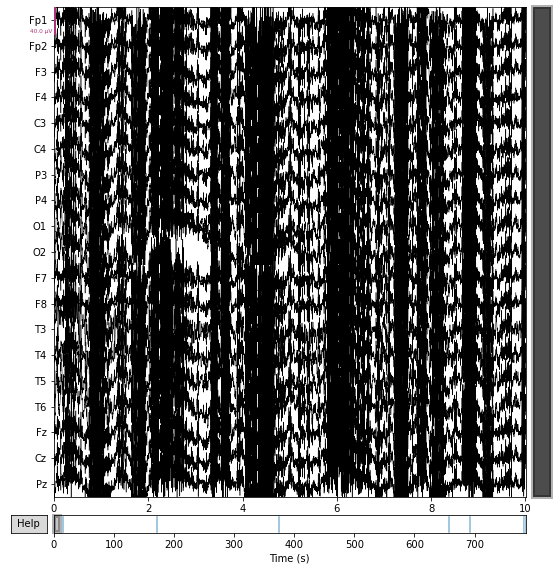

Figure(576x576)


In [39]:
print(raw[87].plot())

## Feature extraction using RBP of 5 frequency bands

In [40]:
def calculate_rbp(files):
    freq_bands = {'delta': (0.5, 4),
                  'theta': (4, 8),
                  'alpha': (8, 13),
                  'beta': (13, 25),
                  'gamma': (25, 45)}

    rbp_values = []

    for data in files:
        psds = []
        freqs = []
        n_channels = data.get_data().shape[0]

        for channel in range(n_channels):
            sfreq = data.info['sfreq']
            window_size = 4.0  # in seconds
            overlap = 0.5  # 50% overlap
            n_fft = int(window_size * sfreq)  # number of FFT points
            n_perseg = int(window_size * sfreq)  # number of samples per segment

            f, p = signal.welch(data.get_data()[channel], fs=sfreq, nperseg=n_perseg,
                                noverlap=int(n_perseg * overlap), nfft=n_fft)
            freqs = f
            psds.append(p)

        psds = np.array(psds)
        total_power = psds.sum()
        rbp = {}

        for band, (fmin, fmax) in freq_bands.items():
            freq_mask = (freqs >= fmin) & (freqs < fmax)
            band_power = psds[:, freq_mask].sum()
            rbp[band] = band_power / total_power

        rbp_values.append(rbp)

    return rbp_values

In [41]:
raw_new = calculate_rbp(raw)

In [42]:
len(raw_new)

88

In [43]:
type(raw_new[0])

dict

In [44]:
raw1 = [];
for i in range(88):
    a = []
    for j in raw_new[i].keys():
        a.append(raw_new[i][j])
    raw1.append(a)

In [45]:
raw_new[0].keys()

dict_keys(['delta', 'theta', 'alpha', 'beta', 'gamma'])

In [46]:
raw_new[0], raw1[0]

({'delta': 0.38560916965109,
  'theta': 0.037353369343327995,
  'alpha': 0.017708690576436443,
  'beta': 0.028627610615708204,
  'gamma': 0.04283818636460708},
 [0.38560916965109,
  0.037353369343327995,
  0.017708690576436443,
  0.028627610615708204,
  0.04283818636460708])

In [47]:
raw1_array = np.array(raw1)

In [48]:
raw1_array.shape

(88, 5)

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

In [50]:
# Encode the labels into numeric values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels_AD_CN)

# Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(raw1_array[:36+29])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for CNN input (assuming each EEG sample has 2548 attributes)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create a sequential model
model1 = Sequential()

# Add the first convolutional layer
model1.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
# model.add(MaxPooling1D(pool_size=2))

# Add the second convolutional layer
model1.add(Conv1D(filters=256, kernel_size=2, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))

# Flatten the output from the previous layer
model1.add(Flatten())

# Add a fully connected layer
model1.add(Dense(256, activation='relu'))

# Add the output layer
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model1.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.6930 - accuracy: 0.4423 - val_loss: 0.6860 - val_accuracy: 0.6154
Epoch 2/100
1/1 [==============================] - 0s 48ms/step - loss: 0.6860 - accuracy: 0.5962 - val_loss: 0.6812 - val_accuracy: 0.5385
Epoch 3/100
1/1 [==============================] - 0s 63ms/step - loss: 0.6804 - accuracy: 0.5577 - val_loss: 0.6764 - val_accuracy: 0.5385
Epoch 4/100
1/1 [==============================] - 0s 40ms/step - loss: 0.6749 - accuracy: 0.5577 - val_loss: 0.6714 - val_accuracy: 0.5385
Epoch 5/100
1/1 [==============================] - 0s 32ms/step - loss: 0.6694 - accuracy: 0.5577 - val_loss: 0.6655 - val_accuracy: 0.5385
Epoch 6/100
1/1 [==============================] - 0s 54ms/step - loss: 0.6634 - accuracy: 0.5577 - val_loss: 0.6585 - val_accuracy: 0.5385
Epoch 7/100
1/1 [==============================] - 0s 56ms/step - loss: 0.6571 - accuracy: 0.5577 - val_loss: 0.6501 - val_accuracy: 0.6154
Epoch 8/100
1/1 [=====

In [51]:
# Evaluate the model on the test set
loss, accuracy = model1.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 [==============================] - 0s 25ms/step - loss: 0.6703 - accuracy: 0.8462
Test Loss: 0.6703338623046875
Test Accuracy: 0.8461538553237915


In [52]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 128)            512       
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 256)            65792     
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 197,889
Trainable params: 197,889
Non-trainable params: 0
_________________________________________________________________


In [53]:
labels_FTD_CN = np.concatenate((np.zeros(29), np.ones(23)));

In [54]:
# Encode the labels into numeric values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels_FTD_CN)

# Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(raw1_array[36:])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for CNN input (assuming each EEG sample has 2548 attributes)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create a sequential model
model2 = Sequential()

# Add the first convolutional layer
model2.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
# model.add(MaxPooling1D(pool_size=2))

# Add the second convolutional layer
model2.add(Conv1D(filters=256, kernel_size=2, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))

# Flatten the output from the previous layer
model2.add(Flatten())

# Add a dropout layer for regularization
model2.add(Dropout(0.5))

# Add a fully connected layer
model2.add(Dense(512, activation='relu'))

# Add a dropout layer for regularization
model2.add(Dropout(0.5))

# Add a fully connected layer
model2.add(Dense(256, activation='relu'))

# Add a dropout layer for regularization
model2.add(Dropout(0.5))

# Add the output layer
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model2.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.6908 - accuracy: 0.6585 - val_loss: 0.6933 - val_accuracy: 0.5455
Epoch 2/100
1/1 [==============================] - 0s 47ms/step - loss: 0.6910 - accuracy: 0.5610 - val_loss: 0.6923 - val_accuracy: 0.5455
Epoch 3/100
1/1 [==============================] - 0s 48ms/step - loss: 0.6911 - accuracy: 0.5366 - val_loss: 0.6914 - val_accuracy: 0.5455
Epoch 4/100
1/1 [==============================] - 0s 47ms/step - loss: 0.6924 - accuracy: 0.5366 - val_loss: 0.6908 - val_accuracy: 0.5455
Epoch 5/100
1/1 [==============================] - 0s 46ms/step - loss: 0.6935 - accuracy: 0.5610 - val_loss: 0.6903 - val_accuracy: 0.5455
Epoch 6/100
1/1 [==============================] - 0s 55ms/step - loss: 0.6890 - accuracy: 0.6098 - val_loss: 0.6896 - val_accuracy: 0.5455
Epoch 7/100
1/1 [==============================] - 0s 40ms/step - loss: 0.6845 - accuracy: 0.5610 - val_loss: 0.6888 - val_accuracy: 0.5455
Epoch 8/100
1/1 [=====

In [55]:
# Evaluate the model on the test set
loss, accuracy = model2.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 [==============================] - 0s 24ms/step - loss: 0.6910 - accuracy: 0.7273
Test Loss: 0.6910051703453064
Test Accuracy: 0.7272727489471436
